<a href="https://colab.research.google.com/github/Abhinandan-Pal/MarkRNN/blob/master/MarksRNN_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing and dowloading**

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from IPython import display
import re
from sklearn.model_selection import train_test_split
import os
import io
import time
import matplotlib.pyplot as plt

In [3]:
# https://github.com/mahnazkoupaee/WikiHow-Dataset
# Refer to this link to get the dataset used

In [4]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [5]:
filePath = "drive/My Drive/MarksRNN/"

In [6]:
import pandas as pd
import random
data = pd.read_csv(filePath + "wikihowAll.csv")

# **Preprocessing**

In [7]:
def newSent(Para,Score):
    Para =  Para.replace("\n\n", "\n").replace("\n\n\n", "\n")
    sentences = Para.split('\n')
    newSents = ""
    for sent in sentences:
        if (random.random() < Score):
            newSents = newSents + "\n" + sent
    return newSents

In [8]:
newData = pd.DataFrame(columns = ['Answer', 'Marking','Score'])
data["text"]= data["text"].astype(str)
data["headline"]= data["headline"].astype(str)
j = 0 
#len(data)
for i in range(999):
    display.clear_output(wait=True)
    print(str(i)+"/"+str(len(data)))
    for score10 in range(5,11):
        newData.loc[j] = [newSent(data['text'][i],score10/10) , data['headline'][i] , score10]
        j = j + 1

998/215365


In [9]:
def preprocess(ans,mark):    
    mark = mark.replace(".,",".")
    ans = re.sub(r'[.]+[\n]+[,]',".\n", ans)
    return ans,mark

In [10]:
answer = []
marking = []
score = []

for i in range(len(newData)):
  if len(newData['Marking'][i] ) < (0.75*len(newData['Answer'][i])):
    if( ( len(newData['Marking'][i])<2000 ) and ( len(newData['Answer'][i] )<4000) ):
      a,b = preprocess(newData['Answer'][i],newData['Marking'][i])
      
      answer.append(a)
      marking.append(b)

      score.append([newData['Score'][i]])

In [11]:
len(answer)

4408

In [12]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [13]:
ans_tensor , ans_token = tokenize(answer)
mark_tensor , mark_token = tokenize(marking)
score_tensor_train = tf.convert_to_tensor(score ,dtype=tf.float32)

In [14]:
print(ans_tensor.shape)
print(mark_tensor.shape)
print(score_tensor_train)

(4408, 769)
(4408, 246)
tf.Tensor(
[[ 5.]
 [ 6.]
 [ 7.]
 ...
 [ 8.]
 [ 9.]
 [10.]], shape=(4408, 1), dtype=float32)


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(mark_token, mark_tensor[0])
print ()


Input Language; index to word mapping
208 ----> 
keep
1749 ----> related
547 ----> supplies
9 ----> in
3 ----> the
209 ----> same
1989 ----> area.
make
32 ----> an
268 ----> effort
2 ----> to
212 ----> clean
4 ----> a
1990 ----> dedicated
1991 ----> workspace
150 ----> after
158 ----> every
1992 ----> session.
place
1111 ----> loose
547 ----> supplies
9 ----> in
1993 ----> large,
686 ----> clearly
1994 ----> visible
1995 ----> containers.
use
1996 ----> clotheslines
6 ----> and
1997 ----> clips
2 ----> to
135 ----> hang
787 ----> sketches,
1112 ----> photos,
6 ----> and
1113 ----> reference
1998 ----> material.
use
158 ----> every
1114 ----> inch
8 ----> of
3 ----> the
873 ----> room
10 ----> for
1999 ----> storage,
391 ----> especially
2000 ----> vertical
2001 ----> space.
use
2002 ----> chalkboard
2003 ----> paint
2 ----> to
44 ----> make
307 ----> space
10 ----> for
2004 ----> drafting
1115 ----> ideas
72 ----> right
16 ----> on
3 ----> the
2005 ----> walls.
purchase
4 ----> a
2006 

In [17]:
BUFFER_SIZE = len(ans_tensor)
BATCH_SIZE = 64
steps_per_epoch = len(ans_tensor)//BATCH_SIZE

vocab_ans_size = len(ans_token.word_index)+1
vocab_mark_size = len(mark_token.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((ans_tensor,mark_tensor,score_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
print(vocab_ans_size)
print(vocab_mark_size)

32602
8964


In [19]:
example_ans_batch, example_mark_batch , example_score = next(iter(dataset))
example_ans_batch.shape, example_mark_batch.shape,example_score.shape

(TensorShape([64, 769]), TensorShape([64, 246]), TensorShape([64, 1]))

# **Setting up model**

In [20]:
class EncoderMark(tf.keras.Model):
  def __init__(self,batch_sz):
    super(EncoderMark, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = 256
    self.embedding = tf.keras.layers.Embedding(vocab_mark_size, 256)
    self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units))
    self.dense = tf.keras.layers.Dense(256, activation='relu')

  def call(self, x):
    x = self.embedding(x)
    x = self.lstm1(x)# initial_state = hidden
    output = self.dense(x)
    return output#, state


In [21]:
class DecoderAns(tf.keras.Model):
  def __init__(self,batch_sz):
    super(DecoderAns, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = 256
    self.embedding = tf.keras.layers.Embedding(vocab_ans_size, 256)
    self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units))
    self.dense1 = tf.keras.layers.Dense(128, activation='relu')
    self.dense2 = tf.keras.layers.Dense(1, activation='relu')

  def call(self, x, hidden):
    x = self.embedding(x)
    encoder_out = tf.expand_dims(hidden, axis=1)
    encoder_out = tf.repeat(encoder_out, repeats=[x.shape[1]], axis=1)
    x = tf.concat([x, encoder_out], 2)
    x = self.lstm1(x)# initial_state = hidden
    x = self.dense1(x)
    output = self.dense2(x)

    return output#, state


In [22]:
encoder = EncoderMark(BATCH_SIZE)

encoder_out = encoder.call(example_mark_batch)

In [23]:
example_ans_batch.shape

TensorShape([64, 769])

In [24]:
decoder = DecoderAns(BATCH_SIZE)
decoder_out = decoder.call(example_ans_batch,encoder_out)

In [25]:
decoder_out.shape

TensorShape([64, 1])

In [26]:
encoder_out = tf.expand_dims(encoder_out, axis=1)
encoder_out = tf.repeat(encoder_out, repeats=[766], axis=1)

In [27]:
encoder_out[1,2,1] == encoder_out[1,3,1]

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [28]:
embedding = tf.keras.layers.Embedding(vocab_ans_size, 64)
inp1 = embedding(example_ans_batch)
inp1.shape[1]

769

# **IMPLEMENTATION**

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_object = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

def loss_function(real, pred):
  loss_ = loss_object(real, pred)
  return loss_ 

In [39]:
@tf.function
def train_step(ans, mark,score):
  loss = 0

  with tf.GradientTape() as tape:

    encoder_out = encoder.call(mark)
    predicted_score = decoder.call(ans,encoder_out)
    loss = loss_function(score,predicted_score)

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return loss

In [31]:
steps_per_epoch

68

In [32]:
encoder.save_weights("encoder_mark.hdf5")


In [33]:
loss_history_train = []
loss_history_val = []

In [42]:
EPOCHS = 2

for epoch in range(EPOCHS):
  start = time.time()

  total_loss = 0
  set_loss = 0
  for (batch, (ans, mark,score)) in enumerate(dataset.take(steps_per_epoch)):
    if (batch % 10 == 0):
      encoder_out = encoder.call(mark)
      predicted_score = decoder.call(ans,encoder_out)
      loss_val = loss_function(score,predicted_score)

      encoder.save_weights("encoder_mark.hdf5")
      decoder.save_weights("decoder_ans.hdf5")

      
      if(batch != 0):
        loss_history_train.append(set_loss/9)
        print('SAVING MODEL TRAIN RESULT: Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   set_loss/9))
      set_loss = 0
      print('VALIDATION RESULT: Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   loss_val.numpy()))
      loss_history_val.append(loss_val.numpy())
    else:
      batch_loss = train_step(ans, mark,score)
      total_loss += batch_loss
      set_loss += batch_loss.numpy()
      if batch % 1 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))

  # saving (checkpoint) the model every 2 epochs

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / (steps_per_epoch*.9)))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

VALIDATION RESULT: Epoch 1 Batch 0 Loss 2.7946
Epoch 1 Batch 1 Loss 2.5458
Epoch 1 Batch 2 Loss 2.7237
Epoch 1 Batch 3 Loss 2.8520
Epoch 1 Batch 4 Loss 2.3226
Epoch 1 Batch 5 Loss 3.0617
Epoch 1 Batch 6 Loss 2.4138
Epoch 1 Batch 7 Loss 3.3585
Epoch 1 Batch 8 Loss 2.4166
Epoch 1 Batch 9 Loss 2.6466
SAVING MODEL TRAIN RESULT: Epoch 1 Batch 10 Loss 2.7046
VALIDATION RESULT: Epoch 1 Batch 10 Loss 2.5548
Epoch 1 Batch 11 Loss 3.1044
Epoch 1 Batch 12 Loss 2.7742
Epoch 1 Batch 13 Loss 3.8480
Epoch 1 Batch 14 Loss 3.1060
Epoch 1 Batch 15 Loss 2.8256
Epoch 1 Batch 16 Loss 2.1832
Epoch 1 Batch 17 Loss 3.2475
Epoch 1 Batch 18 Loss 2.8342
Epoch 1 Batch 19 Loss 3.3171
SAVING MODEL TRAIN RESULT: Epoch 1 Batch 20 Loss 3.0267
VALIDATION RESULT: Epoch 1 Batch 20 Loss 2.4033
Epoch 1 Batch 21 Loss 3.0102
Epoch 1 Batch 22 Loss 3.3079
Epoch 1 Batch 23 Loss 2.6688
Epoch 1 Batch 24 Loss 3.2168
Epoch 1 Batch 25 Loss 2.5939
Epoch 1 Batch 26 Loss 3.1093
Epoch 1 Batch 27 Loss 2.5890
Epoch 1 Batch 28 Loss 2.8699


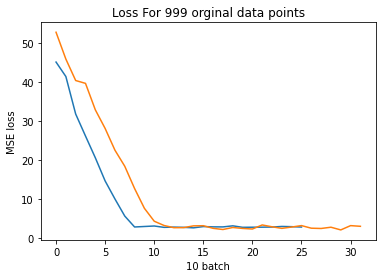

In [44]:
plt.plot(loss_history_train[10:],label="Train")# Blue
plt.plot(loss_history_val[10:],label="Validation")# Yellow 
plt.xlabel("10 batch")
plt.ylabel("MSE loss")
plt.title("Loss For 999 orginal data points")
plt.savefig('Both_model2_999.pdf')  

plt.show()

In [45]:
encoder.save_weights("encoder_mark.hdf5")
decoder.save_weights("decoder_ans.hdf5")